In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Retrieving data with StatAPI

### Imports

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [3]:
from util import stat_to_df
from sentinelhub import (
    SentinelHubRequest, DataCollection, SHConfig,
    SentinelHubStatisticalDownloadClient, SentinelHubStatistical,
    CRS, BBox, Geometry, bbox_to_dimensions, MimeType, WcsRequest
)

In [4]:
# helper function
def to_download_requests(gdf, data_folder=None):
    """ function to create StatAPI request per each geometry in geopandas geoDataFrame 
    
    :param: data_folder: specify a folder to cache the responses from SH service - particularly useful when testing
    """
    
    stat_requests = []
    for row in gdf.itertuples():
        req = SentinelHubStatistical(
            aggregation=aggregation, 
            calculations=calculations, 
            input_data=[input_data], 
            geometry=Geometry(row.geometry, crs=CRS(gdf.crs.to_epsg())),
            data_folder=data_folder
        )
        stat_requests.append(req)
    
    download_requests = [stat_request.download_list[0] for stat_request in stat_requests]
    
    if data_folder:
        for download_request in download_requests:
            download_request.save_response = True
    
    return download_requests

## Fetch statististat_to_df using sh-py + StatAPI

Evalscript to retrieve data:

In [5]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12", "SCL", "dataMask"],
      units: "DN"
    }],
    output: [
      {
        id: "bands",
        bands: ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12"],
        sampleType: "UINT16"
      },
      {
        id: "masks",
        bands: ["CLOUD_MASK"],
        sampleType: "UINT8"
      },
      {
        id: "indices",
        bands: ["NDVI", "NDVI_RE1", "NBSI"],
        sampleType: "UINT16"
      },
      {
        id: "dataMask",
        bands: 1
      }]
  }
}

function evaluatePixel(samples) {
    // Normalised Difference Vegetation Index and variation
    let NDVI = index(samples.B08, samples.B04);
    let NDVI_RE1 = index(samples.B08, samples.B05);

    // Bare Soil Index 
    let NBSI = index((samples.B11 + samples.B04), (samples.B08 + samples.B02));
    
    // Cloud mask from SCL
    // SCL values: 
    // 1=saturated/defective, 2=dark area, 3=cloud shadows, 4=vegetation, 5=bare soil, 
    // 6=water, 7=unclassified, 8=cloud medium probability, 9=cloud high probability, 10=cirrus, 11=snow
    let CLOUD_MASK = (samples.SCL == 8 || samples.SCL == 9 || samples.SCL == 10) ? 1 : 0;
    
    const f = 5000;
    return {
        bands: [samples.B01, samples.B02, samples.B03, samples.B04, samples.B05, samples.B06, 
                samples.B07, samples.B08, samples.B8A, samples.B09, samples.B11, samples.B12],
        masks: [CLOUD_MASK],
        indices: [toUINT(NDVI, f), toUINT(NDVI_RE1, f), toUINT(NBSI, f)],
        dataMask: [samples.dataMask]
    };
}

function toUINT(product, constant){
  // Clamp the output to [-1, 10] and convert it to a UNIT16
  // value that can be converted back to float later.
  if (product < -1) {
    product = -1;
  } else if (product > 10) {
    product = 10;
  }
  return Math.round(product * constant) + constant;
}

function feature_ratio(band_a, band_b, constant){
  // Compute Band Ratio of the form A/B + constant.
  return (band_a / band_b) + constant;
} 

"""

In [6]:
kranj_wgs84 = [14.26, 46.26, 14.51, 46.11]
bbox = BBox(bbox=kranj_wgs84, crs=CRS.WGS84)

In [7]:
time_interval = ('2022-03-01', '2022-09-01')

In [8]:
config = SHConfig()
config.sh_client_id = "sh-7d9b3f44-8ce1-40bf-95b0-77aed421367f"
config.sh_client_secret = "VWIGbtv0VTHybY58JxgZ9BBcNAMVLCuV"
config.instance_id = "f9572672-9031-4b47-876a-a8b4853ca73e"
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
collection_l2a = DataCollection.SENTINEL2_L2A.define_from("s2l2a", service_url=config.sh_base_url)
collection_des = DataCollection.SENTINEL1_IW_DES.define_from("s1des", service_url=config.sh_base_url)
collection_asc = DataCollection.SENTINEL1_IW_ASC.define_from("s1asc", service_url=config.sh_base_url)

In [9]:
wcs_true_color_request = WcsRequest(
    data_collection=collection_l2a,
    data_folder="./cache/",
    layer='TRUE-COLOR-S2-L1C',
    bbox=bbox,
    time=time_interval,
    resx = "60m",
    resy = "60m",
    image_format= MimeType.TIFF,
    config=config
)
images = wcs_true_color_request.get_data(save_data=True)
len(images)

43

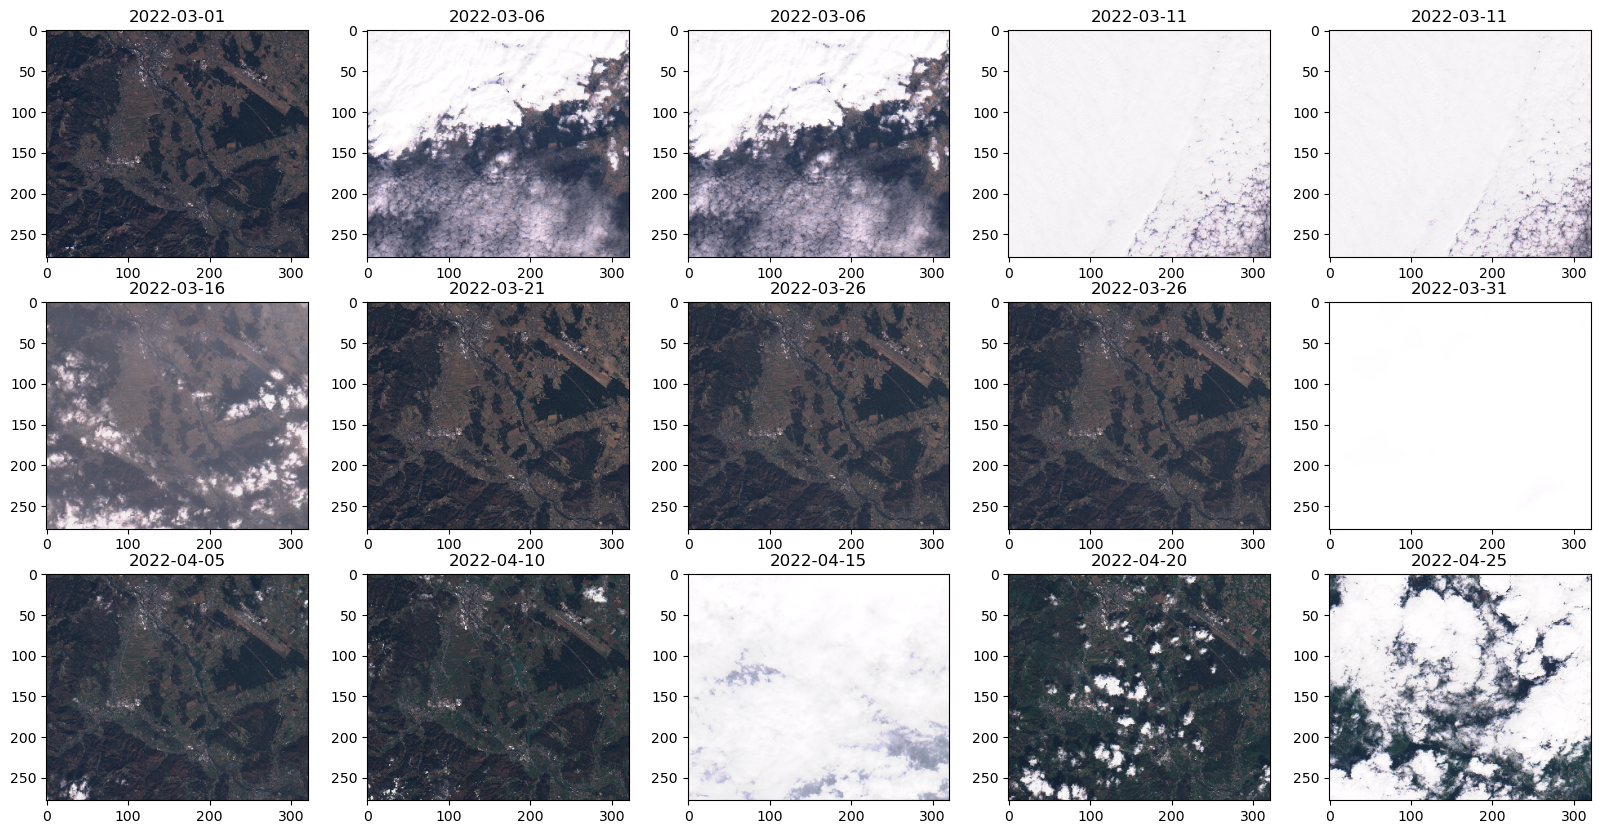

In [10]:
fig, axs = plt.subplots(3,5, figsize=(20,10))
for idx, (image, datum) in enumerate(zip(images[:15], wcs_true_color_request.get_dates()[:15])):
    axs.flat[idx].imshow(image)
    axs.flat[idx].set_title(datum.date().isoformat())

In [11]:
resolution=(10,10)

In [12]:
aggregation = SentinelHubStatistical.aggregation(
    evalscript=evalscript,
    time_interval=time_interval,
    aggregation_interval='P1D',
    size=bbox_to_dimensions(bbox, 100))

In [13]:
input_data = SentinelHubRequest.input_data(collection_l2a, maxcc=1)

<div class="alert alert-block alert-info">
    We will request default statistics + [5,50,90]th percentiles for all outputs.

In [14]:
calculations = {
    "default": {
      "statistics": {
        "default": {
          "percentiles": {
            "k": [5, 50, 95]
          }
        }
      }
    }
}

In [15]:
stats = SentinelHubStatistical(
    aggregation=aggregation, 
    data_folder="./cache/",
    calculations=calculations, 
    input_data=[input_data],
    bbox=bbox,
    config=config
)

In [16]:
%%time
res = stats.get_data(save_data=True)[0]

CPU times: total: 0 ns
Wall time: 6.68 s


<div class="alert alert-block alert-info">
Beware that with StatAPI the response can contain errors for particular intervals. (With FIS, whole response failed if single timestamp failed.) This is how erroneous data looks like:
</div>

```javascript
{'interval': {'from': '2020-12-21T00:00:00Z', 'to': '2020-12-22T00:00:00Z'}, 'error': {'type': 'EXECUTION_ERROR'}}
{'interval': {'from': '2020-12-26T00:00:00Z', 'to': '2020-12-27T00:00:00Z'}, 'error': {'type': 'EXECUTION_ERROR'}}
{'interval': {'from': '2020-12-31T00:00:00Z', 'to': '2021-01-01T00:00:00Z'}, 'error': {'type': 'EXECUTION_ERROR'}}
```

In [17]:
res['data'][0]['interval']

{'from': '2022-03-01T00:00:00Z', 'to': '2022-03-02T00:00:00Z'}

In [18]:
res['data'][2]['outputs']['indices']['bands']['NDVI']

{'stats': {'min': 2035.0,
  'max': 7955.0,
  'mean': 5156.150765385861,
  'stDev': 254.6202320233893,
  'sampleCount': 32010,
  'noDataCount': 0,
  'percentiles': {'5.0': 4857.0, '95.0': 5595.0, '50.0': 5119.0}}}

<div class="alert alert-block alert-info">
Converting the response to `pandas` dataframe, we get:
</div>



In [19]:
res_df = stat_to_df(res)

In [20]:
res_df.head()

,interval_from,interval_to,indices_NDVI_min,indices_NDVI_max,indices_NDVI_mean,indices_NDVI_stDev,indices_NDVI_sampleCount,indices_NDVI_noDataCount,indices_NDVI_percentiles_5.0,indices_NDVI_percentiles_95.0,...,bands_B11_percentiles_50.0,bands_B12_min,bands_B12_max,bands_B12_mean,bands_B12_stDev,bands_B12_sampleCount,bands_B12_noDataCount,bands_B12_percentiles_5.0,bands_B12_percentiles_95.0,bands_B12_percentiles_50.0
0,2022-03-01,2022-03-02,0.0,9805.0,7449.595283,1163.634021,32010,0,5665.0,9061.0,...,1885.0,32.0,4945.0,1260.305654,607.039841,32010,0,335.0,2209.0,1291.0
1,2022-03-06,2022-03-07,328.0,8991.0,5739.698844,752.029039,32010,0,4779.0,7238.0,...,3596.0,82.0,11717.0,3516.181881,2084.043560,32010,0,683.0,7420.0,3161.0
2,2022-03-11,2022-03-12,2035.0,7955.0,5156.150765,254.620232,32010,0,4857.0,5595.0,...,5838.0,1353.0,7914.0,5036.329335,610.463139,32010,0,4022.0,5936.0,5076.0
3,2022-03-16,2022-03-17,2864.0,7984.0,6121.966292,465.321858,32010,0,5280.0,6784.0,...,2693.0,665.0,7534.0,2099.554296,801.757525,32010,0,1151.0,3753.0,2019.0
4,2022-03-21,2022-03-22,0.0,9719.0,7335.319119,1060.928943,32010,0,5650.0,8821.0,...,2144.0,41.0,7885.0,1466.973727,681.807926,32010,0,422.0,2538.0,1486.0


### Conversion function to back to "float"

<div class="alert alert-block alert-info">
As our evalscript is requesting outputs as unsigned integers, we want to transform statistics back:
</div>

In [22]:
float_res_df = res_df.copy()

for index in ["NDVI", "NDVI_RE1", "NBSI"]:
    for stat in ['mean', 'min', 'max', 'stDev', 'percentiles_5.0', 'percentiles_50.0', 'percentiles_95.0']:
        col = f'indices_{index}_{stat}'
        if stat == 'stDev':
            float_res_df[col] = float_res_df[col] / 5000.
        else:
            float_res_df[col] = (float_res_df[col] - 5000.) / 5000.

<div class="alert alert-block alert-info">
Note: statistics for S-2 bands are still in DNs, so should be divided by 1.e4 to get to statistics for reflectances.
</div>

In [23]:
float_res_df.head()

,interval_from,interval_to,indices_NDVI_min,indices_NDVI_max,indices_NDVI_mean,indices_NDVI_stDev,indices_NDVI_sampleCount,indices_NDVI_noDataCount,indices_NDVI_percentiles_5.0,indices_NDVI_percentiles_95.0,...,bands_B11_percentiles_50.0,bands_B12_min,bands_B12_max,bands_B12_mean,bands_B12_stDev,bands_B12_sampleCount,bands_B12_noDataCount,bands_B12_percentiles_5.0,bands_B12_percentiles_95.0,bands_B12_percentiles_50.0
0,2022-03-01,2022-03-02,-1.0000,0.9610,0.489919,0.232727,32010,0,0.1330,0.8122,...,1885.0,32.0,4945.0,1260.305654,607.039841,32010,0,335.0,2209.0,1291.0
1,2022-03-06,2022-03-07,-0.9344,0.7982,0.147940,0.150406,32010,0,-0.0442,0.4476,...,3596.0,82.0,11717.0,3516.181881,2084.043560,32010,0,683.0,7420.0,3161.0
2,2022-03-11,2022-03-12,-0.5930,0.5910,0.031230,0.050924,32010,0,-0.0286,0.1190,...,5838.0,1353.0,7914.0,5036.329335,610.463139,32010,0,4022.0,5936.0,5076.0
3,2022-03-16,2022-03-17,-0.4272,0.5968,0.224393,0.093064,32010,0,0.0560,0.3568,...,2693.0,665.0,7534.0,2099.554296,801.757525,32010,0,1151.0,3753.0,2019.0
4,2022-03-21,2022-03-22,-1.0000,0.9438,0.467064,0.212186,32010,0,0.1300,0.7642,...,2144.0,41.0,7885.0,1466.973727,681.807926,32010,0,422.0,2538.0,1486.0


## Run on all geometries from geodataframe

<div class="alert alert-block alert-info">
    To showcase how to run this on a large(r) number of geometries, using `sh-py` to do the multithreading etc., we've constructed a geoDataFrame with four polygons somewhere in Slovenia, over four different land covers: water, forest, agricultural fields and urban fabric.

In [24]:
gdf = gpd.read_file('data/statapi_kranj.geojson')

In [25]:
gdf.head()

,type,geometry
0,Meadow,"POLYGON ((14.32473 46.23212, 14.32513 46.23046..."
1,Agricultural,"POLYGON ((14.34912 46.25535, 14.34940 46.25345..."
2,Water,"POLYGON ((14.40093 46.20024, 14.40154 46.19887..."
3,Forest,"POLYGON ((14.33880 46.26570, 14.33882 46.26445..."
4,Urban,"POLYGON ((14.35496 46.24100, 14.35427 46.23840..."


calculations = {
    "default": {
      "statistics": {
        "default": {
          "percentiles": {
            "k": [5, 50, 95]
          }
        }
      }
    }
}<div class="alert alert-block alert-info">
    We will convert the geometries to UTM_33N coordinate reference system, as the Sentinel-2 tiles in Slovenia are originally in this UTM, but we could do the requests in WGS as well.

In [26]:
gdf_utm = gdf.to_crs(epsg=32633)

In [27]:
download_requests = to_download_requests(gdf_utm)

In [28]:
client = SentinelHubStatisticalDownloadClient(config=config)
stat_data = client.download(download_requests)

In [29]:
len(stat_data)

5

<div class="alert alert-block alert-info">
    We got back 5 responses, ordered in the same way as the rows in the `gdf_utm` are, so we can construct a full dataframe (adding land cover type) to the responses, and transforming the statistics for indices:


In [30]:
indices = list(stat_data[0]['data'][0]['outputs']['indices']['bands'].keys())
statistics = ['min', 'max', 'mean', 'stDev']

dfs = []
for idx, stat in enumerate(stat_data):
    df = stat_to_df(stat)
    
    for index in indices:
        for stat in statistics:
            col = f'indices_{index}_{stat}'
            if stat == 'stDev':
                df[col] = df[col] / 5000.
            else:
                df[col] = (df[col] - 5000.) / 5000.
    
    df['type'] = gdf_utm.iloc[idx].type
    dfs.append(df)

data = pd.concat(dfs)

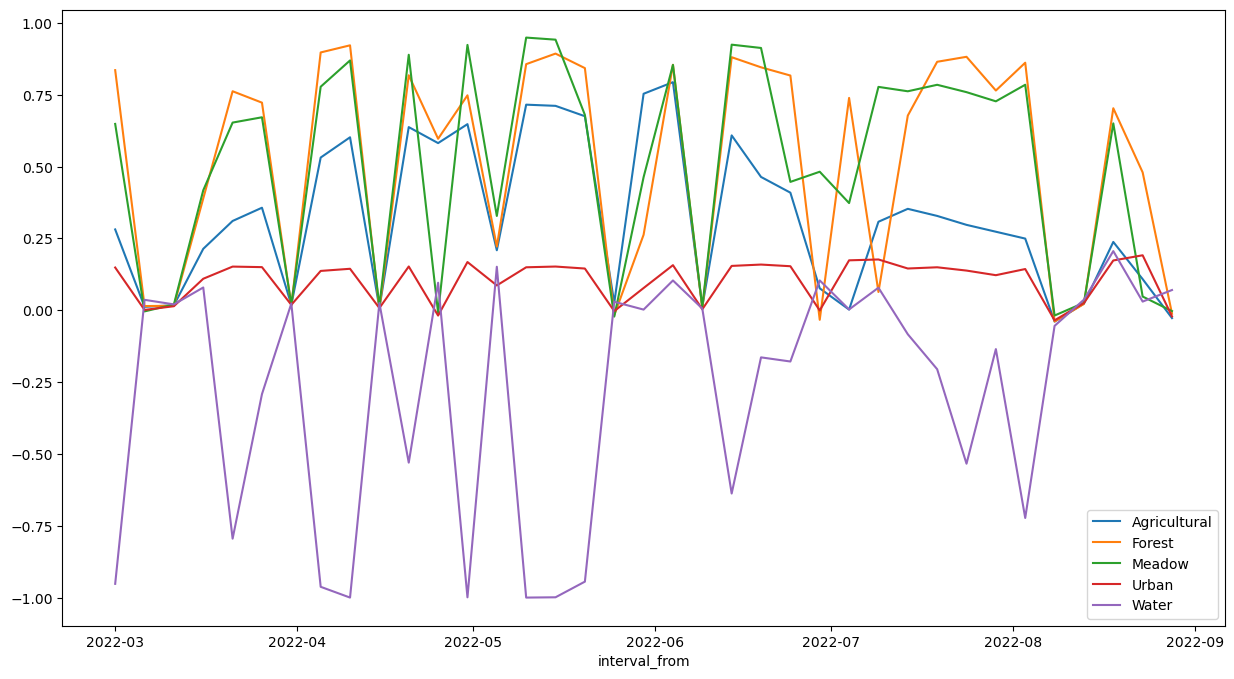

In [31]:
fig, ax = plt.subplots(figsize=(15,8))
data.set_index('interval_from').groupby('type')['indices_NDVI_mean'].plot(ax=ax, legend=True);

It is clear that the four geometries are significantly different from each other, but the time series is very jagged. Let's use the information about the clouds:

In [33]:
data.masks_CLOUD_MASK_mean

,interval_from,interval_to,indices_NDVI_min,indices_NDVI_max,indices_NDVI_mean,indices_NDVI_stDev,indices_NDVI_sampleCount,indices_NDVI_noDataCount,indices_NDVI_percentiles_5.0,indices_NDVI_percentiles_95.0,...,bands_B12_min,bands_B12_max,bands_B12_mean,bands_B12_stDev,bands_B12_sampleCount,bands_B12_noDataCount,bands_B12_percentiles_5.0,bands_B12_percentiles_95.0,bands_B12_percentiles_50.0,type
0,2022-03-01,2022-03-02,0.5080,0.7142,0.648591,0.043785,32010,9987,7814.0,8530.0,...,701.0,1639.0,1220.266721,208.127313,32010,9987,792.0,1524.0,1251.0,Meadow
1,2022-03-06,2022-03-07,-0.0712,0.0566,-0.003947,0.028881,32010,9987,4778.0,5221.0,...,2478.0,6951.0,4403.103119,1336.556596,32010,9987,2528.0,6443.0,4261.0,Meadow
2,2022-03-11,2022-03-12,-0.0034,0.0382,0.020180,0.007183,32010,9987,5033.0,5150.0,...,4260.0,4979.0,4575.708169,181.355282,32010,9987,4345.0,4919.0,4554.0,Meadow
3,2022-03-16,2022-03-17,0.3274,0.4658,0.417691,0.025948,32010,9987,6804.0,7268.0,...,1628.0,1921.0,1813.427326,69.862704,32010,9987,1659.0,1917.0,1826.0,Meadow
4,2022-03-21,2022-03-22,0.4904,0.7314,0.653232,0.049445,32010,9987,7863.0,8600.0,...,1078.0,1759.0,1455.037915,137.677363,32010,9987,1144.0,1684.0,1472.0,Meadow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,2022-08-08,2022-08-09,-0.1766,0.0708,-0.034994,0.042222,32010,11557,4404.0,5101.0,...,1561.0,5751.0,3223.483450,882.166634,32010,11557,2158.0,5001.0,2947.0,Urban
33,2022-08-13,2022-08-14,0.0178,0.0332,0.025365,0.002249,32010,11557,5109.0,5145.0,...,1713.0,1755.0,1734.283577,9.241252,32010,11557,1719.0,1749.0,1735.0,Urban
34,2022-08-18,2022-08-19,0.0546,0.6106,0.173318,0.065966,32010,11557,5487.0,6559.0,...,1727.0,4177.0,2920.365081,418.312027,32010,11557,2260.0,3575.0,2932.0,Urban
35,2022-08-23,2022-08-24,-0.0010,0.4354,0.191383,0.042711,32010,11557,5622.0,6311.0,...,881.0,1319.0,1084.939569,86.470062,32010,11557,962.0,1245.0,1076.0,Urban


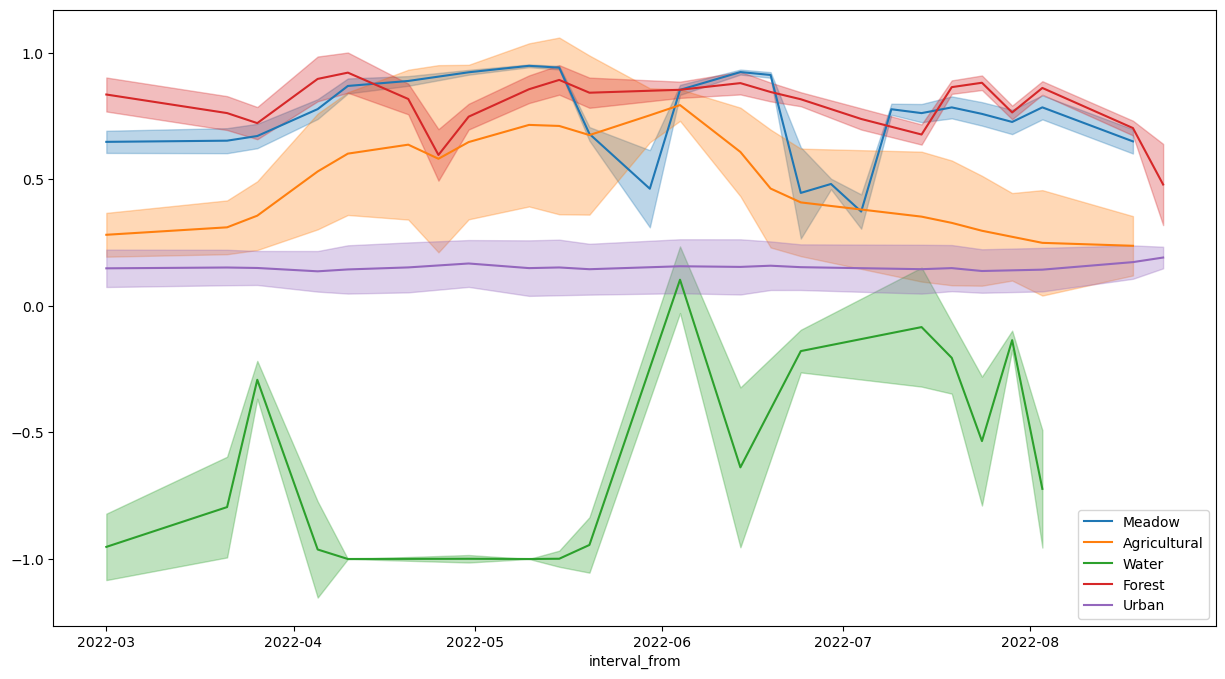

In [34]:
fig, ax = plt.subplots(figsize=(15,8))
filtered = data[data.masks_CLOUD_MASK_mean<0.4]

for idx, _type in enumerate(filtered.type.unique()):
    series = filtered[filtered.type==_type]
    series.plot(ax=ax, x='interval_from', y='indices_NDVI_mean', color=f'C{idx}', label=_type);
    ax.fill_between(series.interval_from.values, series.indices_NDVI_mean-series.indices_NDVI_stDev, series.indices_NDVI_mean+series.indices_NDVI_stDev, color=f'C{idx}', alpha=0.3 );